In [13]:
from IPython.core.display import HTML
HTML("""
<link href="https://fonts.googleapis.com/css2?family=Open+Sans&display=swap" rel="stylesheet">

<style>

div.text_cell_render h1 {
    font-size: 1.5em;
    line-height:1.4em;
    text-align:center;
    }

div.text_cell_render { 
    font-family: 'Open Sans';
    font-size:1.1em;
    line-height:1.5em;
    padding-left:3em;
    padding-right:3em;
    }
</style>
""")

# Interaction with the Google Vision API

_Ruben Ros, 2020_

This notebook describes the process of interacting with the Google Vision API. The API enables researchers to follow the whereabouts of images on the internet through its "web detection" feature. This module returns a list of web adresses (urls) that can subsequently be used to gather information about the images online. This notebook guides the user through the first step: interacting with the Google Vision API.

If you have never worked with a "notebook" like this before: a notebook is essentially a more interactive Python script. A Python script is usually a ".py" file that contains some code. If you have installed python on your system you can run these scripts in a terminal. A python script runs at once. A Jupyter Notebook, however, is a python script that does not run at once, but in cells. You can execute every cell separately, which enables easy exploration of the code you wrote. You can run cells by doing "Shift + Enter" 

### What is an API?

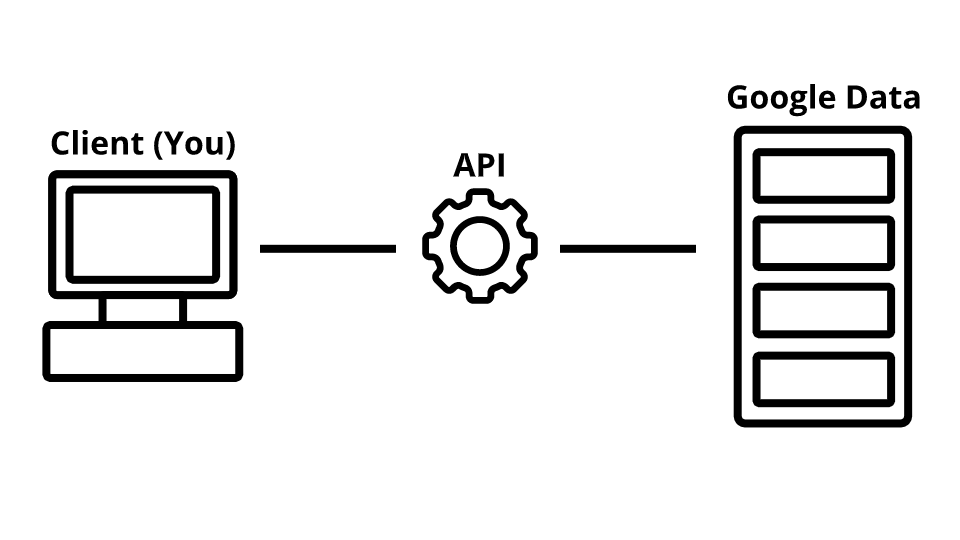

### Setting up your Google Cloud Account

Before we begin the interaction, we need to set up our account at Google. All the steps are described [here](https://cloud.google.com/vision/docs/before-you-begin), but we will walk through them in this notebook as well.

1. Make a Google Account (or use an existing one). You can register [here](https://accounts.google.com/signup/v2/webcreateaccount?service=mail&continue=https%3A%2F%2Fmail.google.com%2Fmail%2F&ltmpl=default&dsh=S-1022536791%3A1581929757665542&gmb=exp&biz=false&flowName=GlifWebSignIn&flowEntry=SignUp). Apparently, you cannot use UU-accounts for this.

2. Google has a broad range of API services. We use only the Cloud Vision API. Activate it [here](https://console.cloud.google.com/flows/enableapi?apiid=vision.googleapis.com&_ga=2.55858594.803327971.1581929623-746618159.1580742281). 

3. Once we have activated the API, it requires authentication. This means that we need to create a project that comes with files that _identify_ that specific project. To do this, create a "service account key" [here](https://console.cloud.google.com/apis/credentials/serviceaccountkey?_ga=2.52048288.803327971.1581929623-746618159.1580742281). Select "new service account" and enter a name for your project. Then, select the role of "owner" for yourself in the project. Lastly, click on "create". This will prompt the download of a .json file. JSON is a popular file type for storing information. In this .json file your project credentials are found. 

### Installing Python and the Vision API Library

Everything in this wonderful world becomes more efficient with Python, one of the most popular programming languages today. For interacting with the API we also use Python. Google even provides a ready-made Python "library": a set of scripts that handle most of the complicated stuff for you.

For installing the Google Vision API Python library we use PIP, a "librarian" for Python. Go to the terminal (type "cmd" in the Windows search bar, or "terminal" in the MacOS search thingy). PIP comes with Python so you should be able to run this in your terminal:

```
pip install google-cloud-vision
```

If PIP is not installed, go to [this website](https://pip.pypa.io/en/stable/installing/), download ```get-pip.py``` and run ```python pip.py```. NOTE: your terminal has no sense of direction. You have to tell it where your beloved python files are located. If you have the ```get-pip.py``` file in your Downloads folder, navigate to it first by doing ```cd ~/Downloads``` in the terminal

In [ ]:
import argparse
import io

from google.cloud import vision
from google.cloud.vision import types


def annotate(path):
    """Returns web annotations given the path to an image."""
    client = vision.ImageAnnotatorClient()

    if path.startswith('http') or path.startswith('gs:'):
        image = types.Image()
        image.source.image_uri = path

    else:
        with io.open(path, 'rb') as image_file:
            content = image_file.read()

        image = types.Image(content=content)

    web_detection = client.web_detection(image=image).web_detection

    return web_detection


def report(annotations):
    """Prints detected features in the provided web annotations."""
    if annotations.pages_with_matching_images:
        print('\n{} Pages with matching images retrieved'.format(
            len(annotations.pages_with_matching_images)))

        for page in annotations.pages_with_matching_images:
            print('Url   : {}'.format(page.url))

    if annotations.full_matching_images:
        print('\n{} Full Matches found: '.format(
              len(annotations.full_matching_images)))

        for image in annotations.full_matching_images:
            print('Url  : {}'.format(image.url))

    if annotations.partial_matching_images:
        print('\n{} Partial Matches found: '.format(
              len(annotations.partial_matching_images)))

        for image in annotations.partial_matching_images:
            print('Url  : {}'.format(image.url))

    if annotations.web_entities:
        print('\n{} Web entities found: '.format(
              len(annotations.web_entities)))

        for entity in annotations.web_entities:
            print('Score      : {}'.format(entity.score))
            print('Description: {}'.format(entity.description))


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter)
    path_help = str('The image to detect, can be web URI, '
                    'Google Cloud Storage, or path to local file.')
    parser.add_argument('image_url', help=path_help)
    args = parser.parse_args()

    report(annotate(args.image_url))

### Interaction through our own Library


The Google Python library has some obvious advantages. It's fast, efficient and made by people who made the API. However, the library has one drawback: using it will cost you your free credits. For that reason we built an alternative library to run "web detection" on an input image. You can load the library by placing the ```scrapelib``` folder and the ```gcv_api.py``` and ```functions.py``` files in the same folder as this notebook. Subsequently we import them, along with some other libraries. If any of these is not installed use pip in the terminal.

In [8]:
import os,sys
from gcv_api import main
from functions import *
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
import concurrent.futures
import logging
import time

Now it's time to run some proper code. When working with large datasets, it's important to have a proper folder structure. In this case, the code needs the following structure:

```
+-- photo_folder
|   +-- example_photo_1_folder
        +-- example_photo_1_folder_source
            +-- example_photo_1.jpg
|   +-- example_photo_2_folder
        +-- example_photo_2_folder_source
            +-- example_photo_2.jpg
```
The scripts going to look at all the photo's in a given folder, starting with the ```source``` folders. It uploads the image files in the folder to Google. 

Now it's time to set some variables. We define 1) the API key from your own account, 2) the path to the folder were all the photos are stored and 3) the name of the photo we want to scrape. We use these variables to construct another one: the input folder ("example_photo_source")

In [9]:
api_key = "api_key"
base_path = "/path/to/photo_folder"
photo = "example_photo"
input_folder_ = os.path.join(base_path,photo,photo + "_" + "source")

Now that we have our input folder, it's time to call the API! We prepared this part for you, which means that you only have to import some functions from the ```gcv_api.py``` file you placed in the same folder as this notebook. If you want to know more about the inner workings of the scraper function, just take a look at the Python scripts in the ```scrapelib``` folder. 

Below we call the API using the ```main.main``` function.  We use the variables we have just set. For now, we just set ```iteration``` to ```1```.

In [10]:
main.main(
            input_folder = input_folder_,
            key = api_key,
            output_folder = os.path.join(base_path, photo, photo + "_"),
            iteration = 1
            )

/path/to/photo_folder\example_photo\example_photo_source


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/path/to/photo_folder\\example_photo\\example_photo_source'

After running this function, you will find several .json files in the output folder. JSON files are very helpful in ordering data. They are structured hierarchically, which means that they contain identifier/values pairs. One of the identifiers is ```pagesWithMatchingImages```. It is under this identifier that we find a list of URLs. These are the pages where your image is located.

We will discuss how to handle these files in the next notebooks. In the remainder of this notebook, we will focus on something else. When your image is famous or iconic, it is likely that there are hundreds, thousands or even millions of associated webpages. The Google API seems to have an internal limit on the number of webpages it returns in one .json file. This is problematic, because we do not know which URLs are returned and which ones are omitted. In fact, it seems that Google just returns the most recent URLs that host your image. 

To solve this (i.e. extent the number of results) we make use of a rather simple trick: we feed the images associated with the URLs found in the [output].json file back into the API. Because the images found by the API are likely to contain small variations: different colortones, dimensions or sizes. Because of this variation, the API tracks new instances of similar images. We can repeat this trick until we encounter no more new URLs.

This method has some implications. First, in theory we are dealing with exponential growth in the number of results. Assuming that each scraped image returns about 100 URLs and that the images present on those webpages are uploaded, we end up with 100 x 100 x 100 x 100 x 100 = 10 billion results after five iterations. Luckily, this is only theory because every iteration will yield many duplicate URLs. It is likely that some URLs reappear after some iterations. This is the reason that we have to remove the duplicates, also because you will burn your free Google Cloud credits fast if you just upload the same image over and over.

Below we upload the results from the first iteration "back" into the API. To do so, we need to gather all the web addresses of the images. These are also included in the .json files. To make things easier, we included a function to gather them in the ```functions.py``` file. We indicate the iteration number in the variable n.

In [11]:
n = 1

In [ ]:
list_json = [os.path.join(base_path, photo, photo + "_" + str(n),f) for f in os.listdir(os.path.join(base_path,photo,photo + "_" + str(n))) if '.json' in f]
print('looking for scraped image URLs in {}'.format(list_json))
image_url_current = Json.extract_image_folder(list_json)

Now we have all the URLs referring to the actual images in the variable ```image_url_current```. After we check if the list is longer than 1 (otherwise we don't have anything to download) we download the images to our own computer. The previously defined variables are used to create a new folder called ```img``` in the folder belonging to the nth iteration. Because scraping uses some additional libraries that are a bit complex, you can call the scraping function ```Im.scrape``` to your list of URLs. Don't forget to set the so-called environment variable to the destination folder.

In [ ]:
# Check if there are Images to Scrape, if not: break and go to next Photo
if len(image_url_current) == 0 or image_url_current is None:
    print("No URLs found in Iteration {}, going to next photo".format(n))

In [ ]:
# Scrape images
images_destination = os.path.join(base_path,photo,photo + "_" + str(n), "img")
if not os.path.exists(images_destination):
    os.makedirs(images_destination)

os.chdir(images_destination)
Im.Scrape(image_url_current)

After downloading all the images, there is one thing left to do: remove the duplicates based on the URLs in the JSON. In subsequent iterations of scraping we do this in advance (remove duplicate URLs from the list). Additionally, we remove images that are very small. The threshold size is currently 4000 bytes.

In [ ]:
# Remove duplicates
if len(image_url_current) > 1:
    Im.RemoveSmall(images_destination,4000)
    Duplicates.remove(images_destination)

## Full Pipeline

Below you find the full pipeline. Choose the iteration (starting with 1) and the photo name and just run the cell.

In [ ]:
photo = "photo_name"
n = args.iteration

# Configuration
base_path = "path/to/photo"
api_key = "API-key"
print('Working on Photo: {}, Iteration'.format(photo,n))


# Post Images to API
if int(n) == 1:
    input_folder_ = os.path.join(base_path, photo, photo + "_" + "source")

if int(n) > 1:
    input_folder_ = os.path.join(base_path, photo, photo + "_" + str(int(n)-1), "img")

try:
    main.main(
            input_folder = input_folder_,
            key = api_key,
            output_folder = os.path.join(base_path, photo, photo + "_"),
            iteration = n
            )
except Exception as e:
    print(e)
    dfr = dfr.append(pd.DataFrame([photo,int(n)-1]).T)
    exit()

# Gather Image URLs from Output files (.json files) and (if n > 1) remove duplicates
list_json = [os.path.join(base_path, photo, photo + "_" + str(n),f) for f in os.listdir(os.path.join(base_path,photo,photo + "_" + str(n))) if '.json' in f]
print('looking for scraped URLs in {}'.format(list_json))
image_url_current = Json.extract_image_folder(list_json)

if int(n) > 1:
    processed_urls = []
    for iter_previous in range(1,int(n)):
        list_json_prev = [os.path.join(base_path, photo, photo + "_" +str(iter_previous),f) for f in os.listdir(os.path.join(base_path,photo,photo + "_" + str(iter_previous))) if '.json' in f]
        print('looking for previous URLs in {}'.format(list_json_prev))
        image_url = Json.extract_image_folder(list_json_prev)
        processed_urls = processed_urls + image_url

    duplicates = [u for u in image_url_current if u in processed_urls]
    print("{}/{} image-URLs removed (duplicates)".format(len(duplicates),len(image_url_current)))
    image_url_current = [u for u in image_url_current if u not in list(set(processed_urls))]

# Check if there are Images to Scrape, if not: break and go to next Photo
if len(image_url_current) == 0 or image_url_current is None:
    print("No URLs found in Iteration {}, going to next photo".format(n))
    exit()

# Scrape images
images_destination = os.path.join(base_path,photo,photo + "_" + str(n), "img")
if not os.path.exists(images_destination):
    os.makedirs(images_destination)

os.chdir(images_destination)
Im.Scrape(image_url_current)

# Remove duplicates
if len(image_url_current) > 1:
    Im.RemoveSmall(images_destination,4000)
    Duplicates.remove(images_destination)